Import the libraries necessary to analize data

In [123]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [124]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              187534 non-null  datetime64[ns]
 1   state                             187534 non-null  object        
 2   city_or_county                    187534 non-null  object        
 3   latitude                          187534 non-null  float64       
 4   longitude                         187534 non-null  float64       
 5   congressional_district            187534 non-null  int64         
 6   avg_age_participants              187534 non-null  float64       
 7   n_participants_child              187534 non-null  int64         
 8   n_participants_teen               187534 non-null  int64         
 9   n_females                         187534 non-null  float64       
 10  n_killed                        

Since in the TASK 3, we need to define a boolean variable representing the class, we decide to pre-calculate it to label the PCA results after the normalization and see how the class is distributed

In [125]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0) 

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [126]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing',
       ]
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)

In [127]:
numeric_attributes = [item for item in df.columns if item not in column_to_drop]
numeric_attributes

['avg_age_participants',
 'povertyPercentage',
 'child_percentage_per_district',
 'teen_percentage_per_district',
 'killed_percentage_per_district',
 'injured_percentage_per_district',
 'arrested_percentage_per_district',
 'unharmed_percentage_per_district',
 'killed_rate',
 'injured_rate',
 'arrested_rate',
 'survival_rate',
 'n_harmed',
 'winning_party_percentage']

In [128]:
df[numeric_attributes].describe()

,avg_age_participants,povertyPercentage,child_percentage_per_district,teen_percentage_per_district,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_rate,injured_rate,arrested_rate,survival_rate,n_harmed,winning_party_percentage
count,187534.000000,187534.00000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000
mean,29.887716,12.67013,0.005924,0.008825,0.009177,0.009182,0.009070,0.009156,0.163842,0.303845,0.248404,0.176173,1.189843,0.681677
std,10.385832,2.71095,0.060906,0.048556,0.028988,0.026519,0.031469,0.031441,0.328084,0.410233,0.386724,0.326824,1.043030,0.130526
min,0.000000,5.60000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,10.90000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.597980
50%,30.000000,12.40000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.668029
75%,31.000000,14.20000,0.000000,0.000000,0.000000,0.007299,0.008696,0.001808,0.000000,0.500000,0.500000,0.250000,2.000000,0.749041
max,101.000000,20.80000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,63.000000,1.000000


In [129]:
# To reduce variance, appliable to positive values
attr_to_log = ['avg_age_participants', 'povertyPercentage']
df[attr_to_log] = np.log(df[attr_to_log].values)
df[attr_to_log] = df[attr_to_log].replace(-np.inf, 0)
df[attr_to_log] = df[attr_to_log].fillna(value=0) 

C:\Users\mitol\AppData\Local\Temp\ipykernel_11464\857541600.py:3: RuntimeWarning: divide by zero encountered in log
  df[attr_to_log] = np.log(df[attr_to_log].values)


In [130]:
df_numeric = df.drop(columns=column_to_drop)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   avg_age_participants              187534 non-null  float64
 1   povertyPercentage                 187534 non-null  float64
 2   child_percentage_per_district     187534 non-null  float64
 3   teen_percentage_per_district      187534 non-null  float64
 4   killed_percentage_per_district    187534 non-null  float64
 5   injured_percentage_per_district   187534 non-null  float64
 6   arrested_percentage_per_district  187534 non-null  float64
 7   unharmed_percentage_per_district  187534 non-null  float64
 8   killed_rate                       187534 non-null  float64
 9   injured_rate                      187534 non-null  float64
 10  arrested_rate                     187534 non-null  float64
 11  survival_rate                     187534 non-null  f

## Normalization

A good practice is to scale data to avoid that some features dominates the others in the clustering, so we done it

In [131]:
scaler = StandardScaler()
X = scaler.fit_transform(df_numeric.values)
scaled_df = pd.DataFrame(X, columns=df_numeric.columns)

## PCA

We do the PCA analysis to visualize in 2D the distribution of our multi-dimensional data

In [132]:
scaled_df[column_to_drop] = df[column_to_drop]

In [133]:
pca = PCA(n_components=2)

In [134]:
scaled_df[['pc1','pc2']] = pca.fit_transform(scaled_df[numeric_attributes])

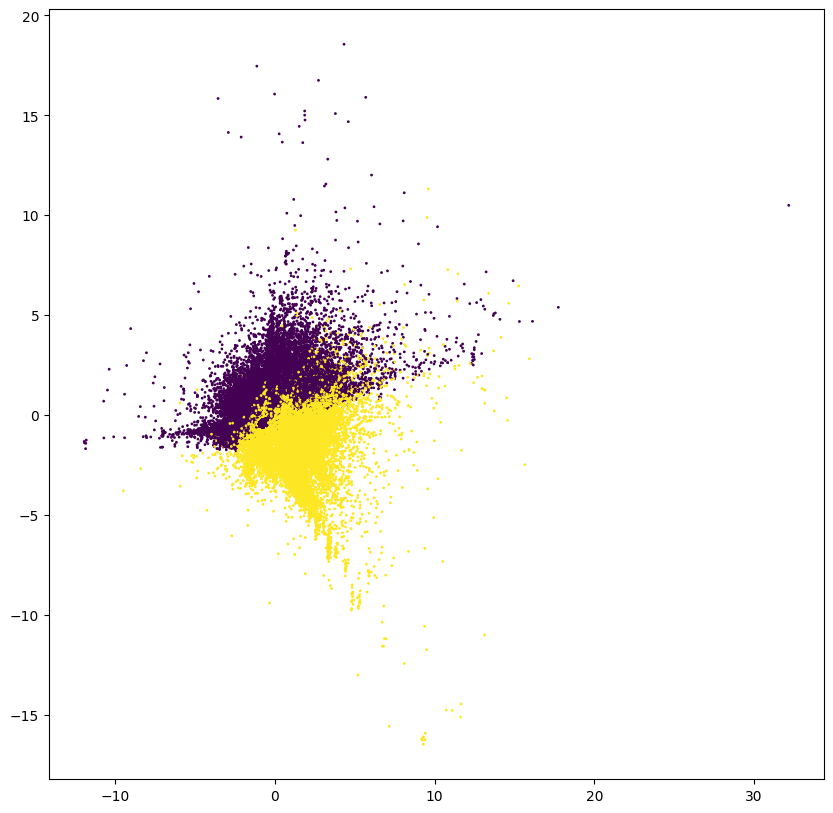

In [135]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['involve_killing'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()

# create a new legend with the state names and colors
#plt.legend(handles, scaled_df['state'].unique())

# display the plot
plt.show()

## Saving the normalized dataset

In [136]:
scaled_df.to_csv('df_scaled.csv', index=False)